# Segment Anything Model using transformers 🤗 library

## References

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb

In [144]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [145]:
from PIL import Image
import cv2
import io
import requests
from skimage.morphology import disk

def find_centroid(img):
    img = np.array(img, dtype=np.uint8)
    _, binary_mask = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, disk(9))
    masked_image = cv2.bitwise_and(img, img, mask=opened_mask)
    contours, _ = cv2.findContours(masked_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return [cX, cY]

def decode_masks(masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]

    for mask in masks:
      h, w = mask.shape[-2:]
      yield np.array(mask.reshape(h, w, 1)).astype(np.uint8)

def preprocessing(case):
    # Load the image from the URL
    img = np.array(Image.open(io.BytesIO(requests.get('http://127.0.0.1:9000/ddsm/od_images/'+case).content)))
    centroid = find_centroid(img)
    raw_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    inputs = processor(raw_image, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    
    input_points = [[centroid]]
    
    inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
    # pop the pixel_values as they are not neded
    inputs.pop("pixel_values", None)
    inputs.update({"image_embeddings": image_embeddings})

    with torch.no_grad():
        outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    
    mask = next(decode_masks(masks[0], scores))
    contour_image = cv2.bitwise_and(raw_image,raw_image,mask=mask)

    """
       Furthermore, we use magma color mapping from 16-bit grayscale to 24-bit RGB,
    """
    false_colored_img = cv2.applyColorMap(contour_image, cv2.COLORMAP_MAGMA)

    return cv2.resize(false_colored_img, (224, 336))

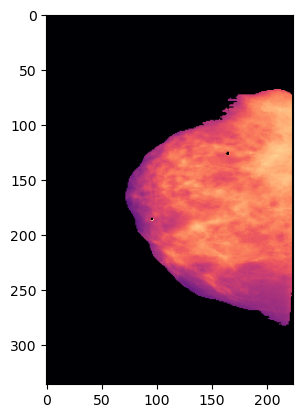

In [156]:
plt.imshow(cv2.cvtColor(preprocessing('A_1766_1.LEFT_CC.tif'), cv2.COLOR_BGR2RGB))

# Manual preprocessing

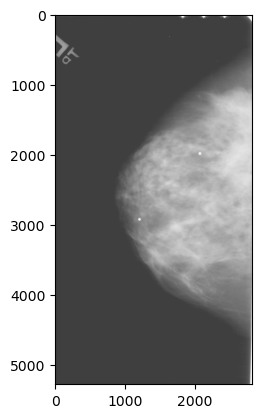

In [161]:
raw_image = np.array(Image.open(io.BytesIO(requests.get('http://127.0.0.1:9000/ddsm/od_images/'+'A_1766_1.LEFT_CC.tif').content)))
rgb_raw_image = cv2.cvtColor(raw_image,cv2.COLOR_BGR2RGB)
plt.imshow(rgb_raw_image)

In [163]:
inputs = processor(rgb_raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

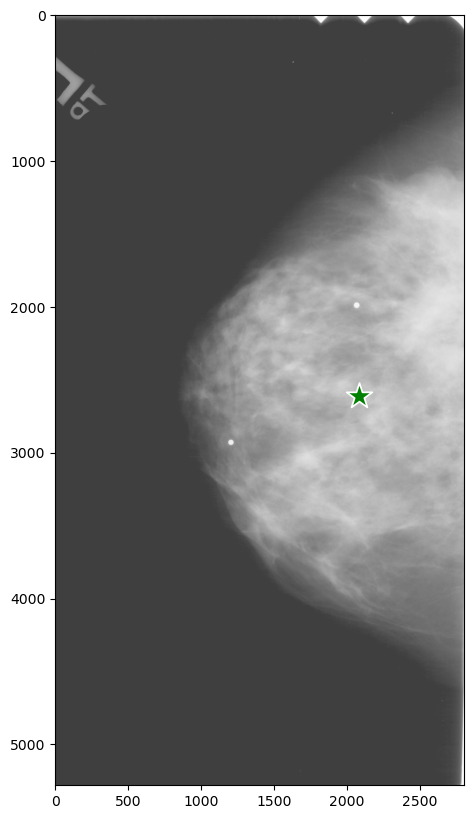

In [162]:
input_points = [[find_centroid(raw_image)]]
show_points_on_image(rgb_raw_image, input_points[0])

In [164]:
inputs = processor(rgb_raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

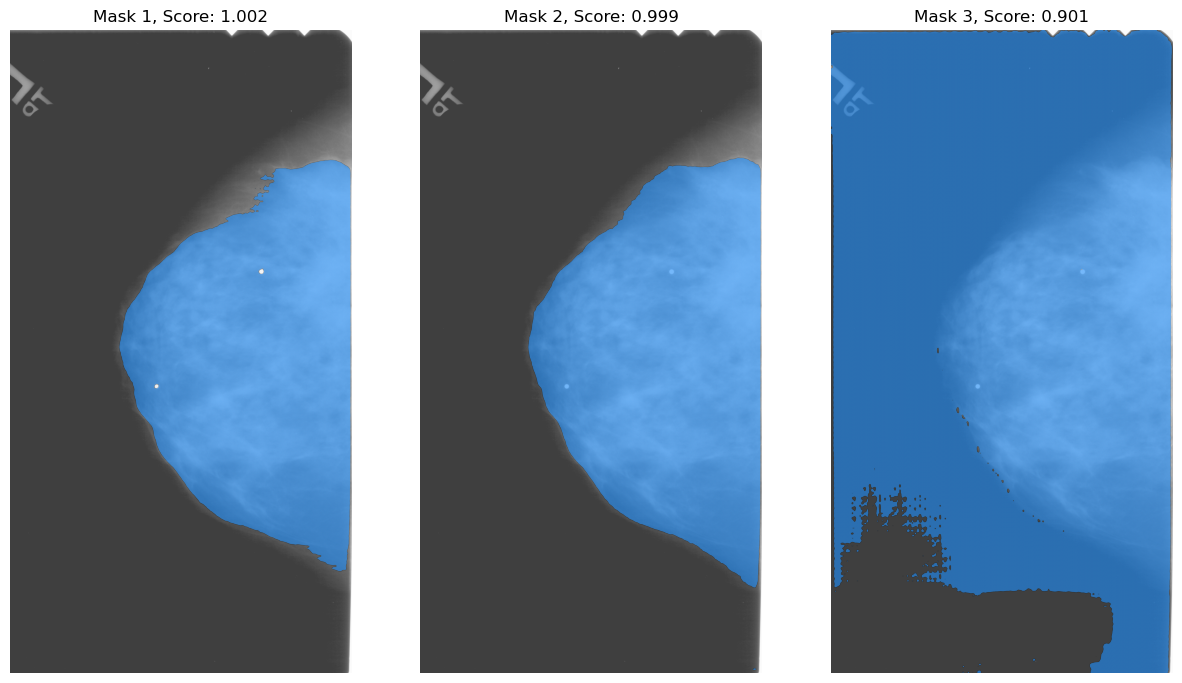

In [165]:
show_masks_on_image(rgb_raw_image, masks[0], scores)